In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [2]:
veriseti = pd.read_csv('./magaza_yorumlari.csv', encoding='utf-16')
print(type(veriseti))
display(veriseti.head())

print("\n---null veri seti sayısı----")
print(veriseti.isnull().sum())
veriseti.dropna(inplace=True)
print("\n---temizlemek sonra null sayısı----")
print(veriseti.isnull().sum())


<class 'pandas.core.frame.DataFrame'>


,Görüş,Durum
0,Ürün gayet güzel boyutları dört kişilik aile ...,Olumlu
1,Ürünü kullandım gayet memnunum,Olumlu
2,Hızlı kargo,Olumlu
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,Olumsuz
4,ürün fena değil ancak gövdenin plastik olması ...,Olumlu



---null veri seti sayısı----
Görüş    2
Durum    0
dtype: int64

---temizlemek sonra null sayısı----
Görüş    0
Durum    0
dtype: int64


In [3]:
label_mapping = {'Olumsuz': 0, 'Olumlu': 1}
veriseti['Durum'] = veriseti['Durum'].map(label_mapping)
display(veriseti.head())

,Görüş,Durum
0,Ürün gayet güzel boyutları dört kişilik aile ...,1
1,Ürünü kullandım gayet memnunum,1
2,Hızlı kargo,1
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0
4,ürün fena değil ancak gövdenin plastik olması ...,1


In [4]:
nltk.download('stopwords')

ineffective = stopwords.words('turkish')

def clean_and_normalize_text(text):
    unwanted_pattern = r'[!.\n,:“”,?@#/"]'
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = cleaned_text.lower()
    
    tokens = nltk.word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word not in ineffective]
    return ' '.join(tokens)

veriseti['new_text'] = veriseti['Görüş'].astype(str).apply(clean_and_normalize_text)
display(veriseti.head(5000))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\modek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Görüş,Durum,new_text
0,Ürün gayet güzel boyutları dört kişilik aile ...,1,ürün gayet güzel boyutları dört kişilik aile y...
1,Ürünü kullandım gayet memnunum,1,ürünü kullandım gayet memnunum
2,Hızlı kargo,1,hızlı kargo
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0,yıl önce lg lm serisi almıştım tv den gayet me...
4,ürün fena değil ancak gövdenin plastik olması ...,1,ürün fena değil ancak gövdenin plastik olması ...
...,...,...,...
4995,idare eder ://///,0,idare eder
4996,ürünü begenmem icin urunun gelmesi lazim.ama o...,0,ürünü begenmem icin urunun gelmesi lazim ortad...
4997,Ürünü satıncaya kadar çok iyi 2 yıl garanti bi...,0,ürünü satıncaya kadar iyi yıl garanti bitince ...
4998,rengi mutfagima aradigim bir tondu.islevide ga...,1,rengi mutfagima aradigim bir tondu islevide ga...


In [5]:
X_tr,X_te,Y_tr,Y_te = train_test_split(veriseti['new_text'], veriseti['Durum'], test_size=0.2, random_state=123)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_tr)
X_test_tfidf = tfidf.transform(X_te)

Model: LogisticRegression
Accuracy: 0.8904593639575972


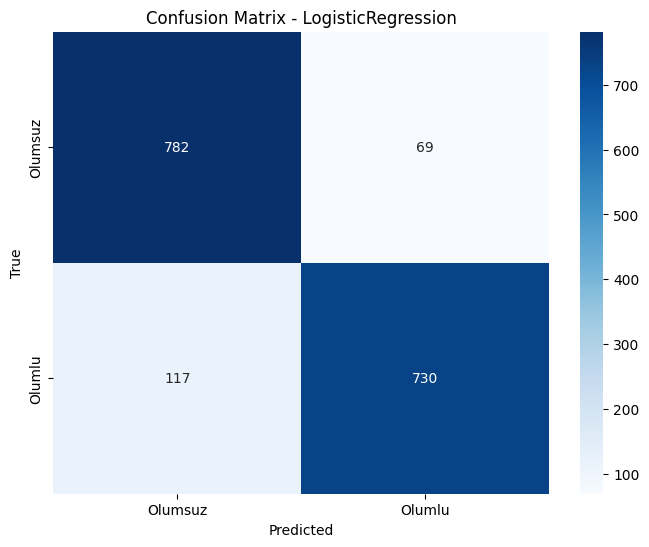

Model: SVC
Accuracy: 0.8916372202591284


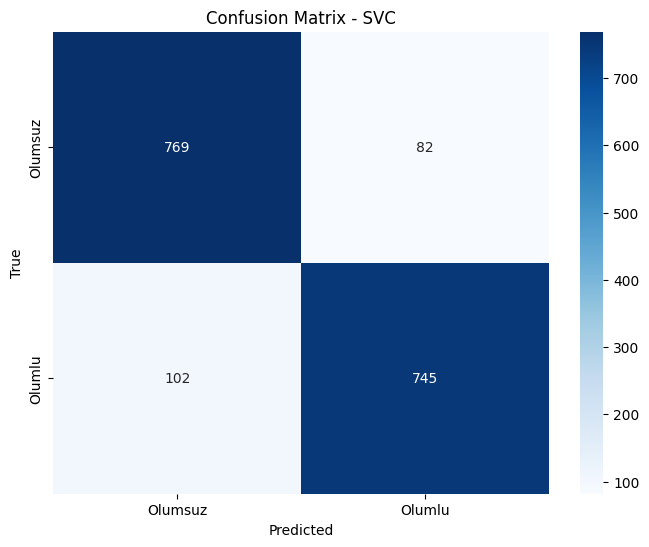

Model: RandomForestClassifier
Accuracy: 0.8610129564193169


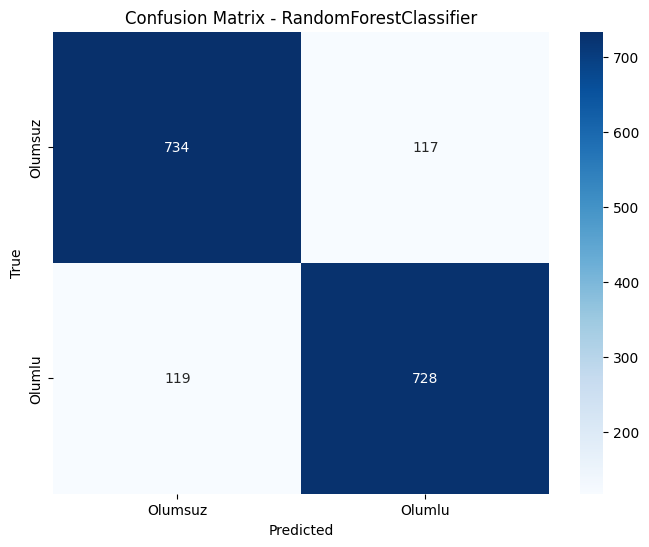

Model: GradientBoostingClassifier
Accuracy: 0.8239104829210836


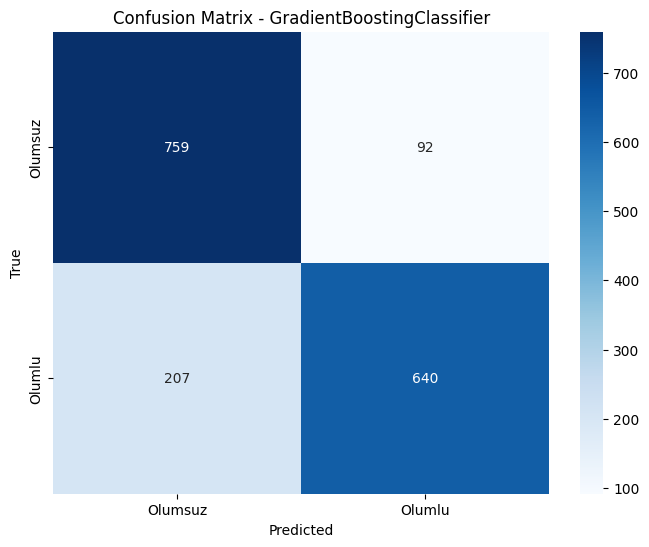

Model: MultinomialNB
Accuracy: 0.8898704358068316


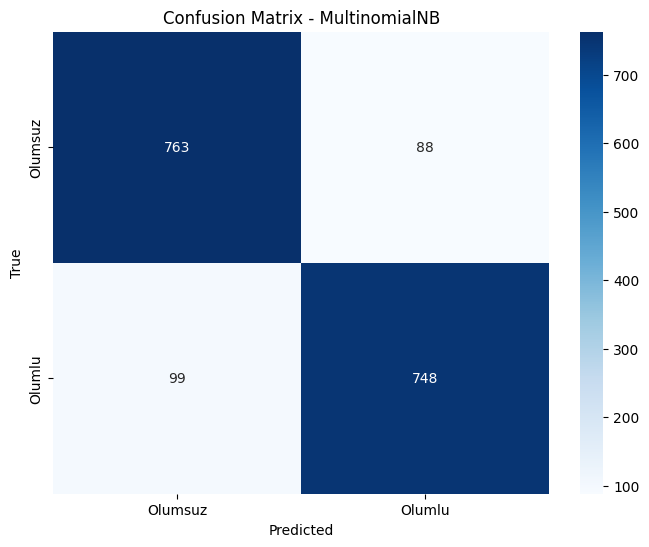

Model: XGBClassifier
Accuracy: 0.85924617196702


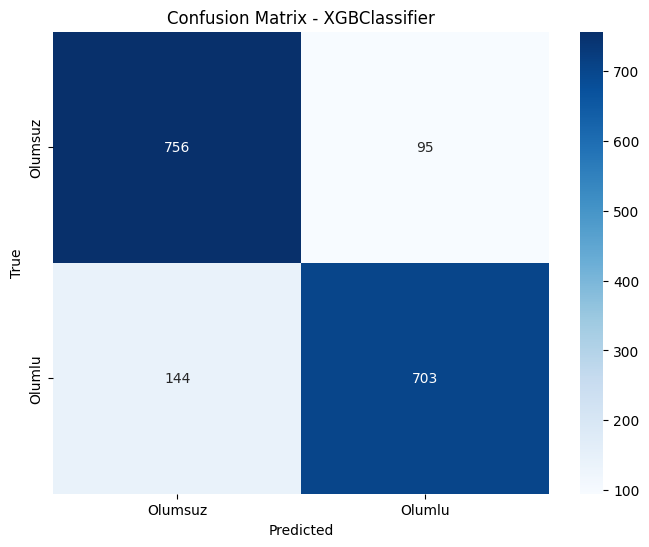

Best model: SVC with accuracy: 0.8916372202591284


In [6]:
models = [
    LogisticRegression(),
    SVC(kernel='linear', probability=True),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    XGBClassifier()
]


def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Olumsuz', 'Olumlu'], yticklabels=['Olumsuz', 'Olumlu'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

best_model = None
best_accuracy = 0

for model in models:    
    train_and_evaluate_model(model, X_train_tfidf, X_test_tfidf, Y_tr, Y_te)
    
    accuracy = accuracy_score(Y_te, model.predict(X_test_tfidf))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


print(f"Best model: {best_model.__class__.__name__} with accuracy: {best_accuracy}")


Sentence sentiment: Positive
Word sentiments:
güzel: Positive (Positive: 100.00%, Negative: 0.00%)
güzel ürün: Positive (Positive: 99.61%, Negative: 0.39%)
hızlı: Positive (Positive: 99.02%, Negative: 0.98%)
hızlı teslimat: Positive (Positive: 98.28%, Negative: 1.72%)
teslimat: Positive (Positive: 89.17%, Negative: 10.83%)
ürün: Positive (Positive: 60.05%, Negative: 39.95%)
ürün hızlı: Positive (Positive: 81.53%, Negative: 18.47%)


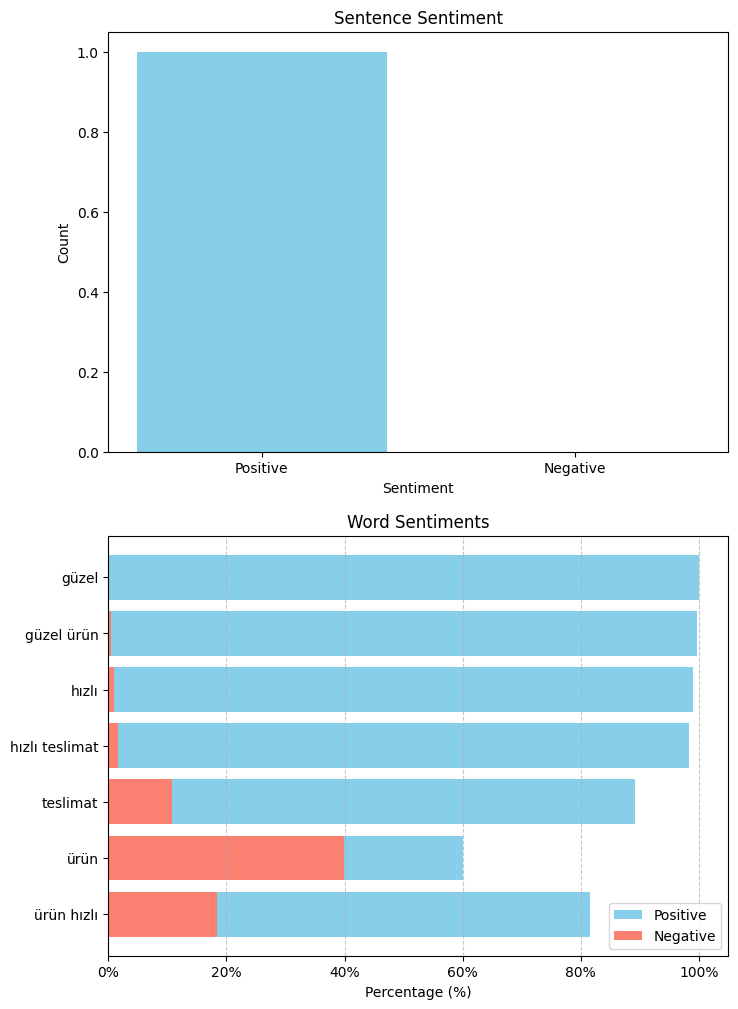

In [7]:
pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', best_model)
])
pipeline.fit(veriseti['new_text'], veriseti['Durum'])

def predict_sentiment(text):
    processed_text = clean_and_normalize_text(text)
    vectorized_text = pipeline.named_steps['vectorizer'].transform([processed_text])
    sentence_prediction = pipeline.named_steps['classifier'].predict(vectorized_text)[0]
    sentence_prediction_label = 'Positive' if sentence_prediction == 1 else 'Negative'
    vectorized_text_array = vectorized_text.toarray()[0]
    
    words = pipeline.named_steps['vectorizer'].get_feature_names_out()
    filtered_words = [words[i] for i, value in enumerate(vectorized_text_array) if value > 0 and words[i] not in ineffective]
    word_sentiments = {}
    for word in filtered_words:
        word_vectorized = pipeline.named_steps['vectorizer'].transform([word])
        word_prediction = pipeline.named_steps['classifier'].predict(word_vectorized)[0]
        word_proba = pipeline.named_steps['classifier'].predict_proba(word_vectorized)[0]
        positive_proba = word_proba[1]
        negative_proba = word_proba[0]
        
        word_sentiments[word] = {
            'label': 'Positive' if word_prediction == 1 else 'Negative',
            'positive_percentage': positive_proba * 100,
            'negative_percentage': negative_proba * 100
        }
    
    return sentence_prediction_label, word_sentiments

test_text = "Güzel ürün. Hızlı teslimat"
sentence_sentiment, word_sentiments = predict_sentiment(test_text)
print(f"Sentence sentiment: {sentence_sentiment}")
print("Word sentiments:")
for word, sentiment in word_sentiments.items():
    print(f"{word}: {sentiment['label']} (Positive: {sentiment['positive_percentage']:.2f}%, Negative: {sentiment['negative_percentage']:.2f}%)")

words = list(word_sentiments.keys())
positive_percentages = [sentiment['positive_percentage'] for sentiment in word_sentiments.values()]
negative_percentages = [sentiment['negative_percentage'] for sentiment in word_sentiments.values()]

fig, ax = plt.subplots(2, 1, figsize=(8, 12))

sentence_labels = ['Positive', 'Negative']
sentence_sizes = [sentence_sentiment.count('Positive'), sentence_sentiment.count('Negative')]
ax[0].bar(sentence_labels, sentence_sizes, color=['skyblue', 'salmon'])
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Count')
ax[0].set_title('Sentence Sentiment')

ax[1].barh(words, positive_percentages, label='Positive', color='skyblue')
ax[1].barh(words, negative_percentages, label='Negative', color='salmon')
ax[1].set_xlabel('Percentage (%)')
ax[1].set_title('Word Sentiments')
ax[1].legend()
ax[1].xaxis.set_major_formatter('{x:.0f}%')
ax[1].invert_yaxis()
ax[1].grid(axis='x', linestyle='--', alpha=0.7) 

plt.show()